In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from model import NeuralNetwork, NeuralNetwork_Adjustable
from utils import count_parameters, plot_metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryAccuracy, AUROC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
#from sklearn import metrics

import matplotlib.pyplot as plt
from IPython.display import clear_output

from time import time

import gc

In [3]:

################################################################ device settings ################################################################
dtype  = 'np.float32'
device = device = "cpu" if torch.backends.mps.is_available() else "cpu"   #torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")
print(f'Selected device: {device}')
################################################################ Data Preparation ################################################################
sample_size  = int(1e+6)
print('Preparing data...')
start = time()
       
df  = pd.read_hdf(f'/Users/asugu/Desktop/b_tag_DNN/data/all_data_{sample_size}.hdf5', key='data', dtype=dtype)   
df = df.astype(np.float32)  
df['pt_cosh']=df['jet_pt']*np.cosh(df['jet_eta']) 

Selected device: cpu
Preparing data...


In [12]:
col_names = df.keys()
target_col_name = "jet_flavor"
input_col_names = [col_name for col_name in col_names if col_name != target_col_name]
df.replace({"inf": 0, "-inf": 0}, inplace=True)

df = df[(np.abs(df-df.mean()) <= 10*df.std()).all(axis=1)]

inputs = df[input_col_names]
labels = df[target_col_name] 
labels = (labels==5).astype(int)  # changes to 1 or 0

del df
gc.collect()

0

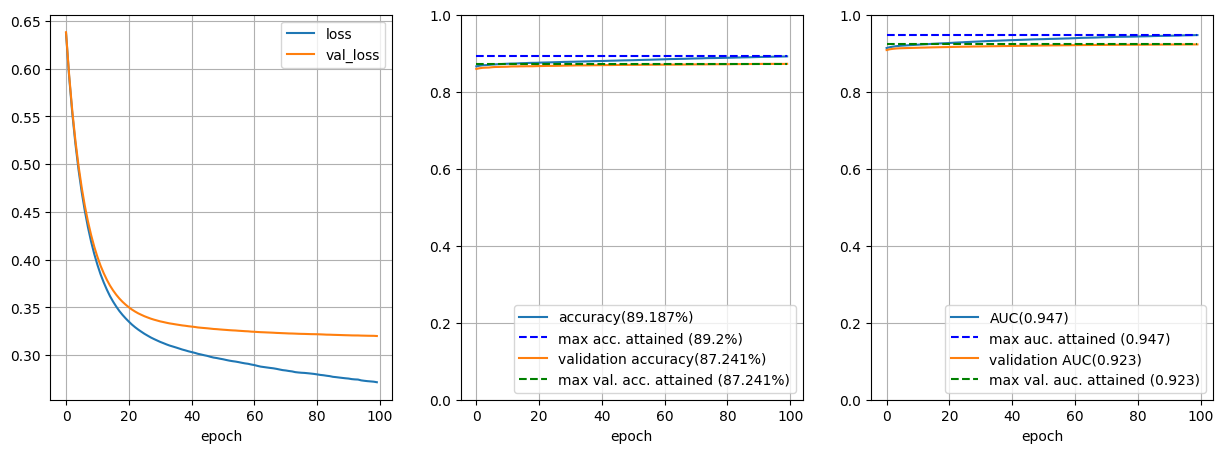

In [26]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(inputs, labels, stratify=labels, test_size=0.2, shuffle=True, random_state=42)

scaler = StandardScaler()
train_inputs = scaler.fit_transform(train_inputs)
val_inputs = scaler.transform(val_inputs)

train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
val_inputs = torch.tensor(val_inputs, dtype=torch.float32)

dtrain = xgb.DMatrix(train_inputs, label=train_labels)    
dval = xgb.DMatrix(val_inputs, label=val_labels)

params = {
    'max_depth': 10,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error', 'auc']
}

num_rounds = 50
eval_results = {} 

model = xgb.train(params, dtrain, num_rounds, evals=[(dtrain, 'train'), (dval, 'validation')], evals_result=eval_results)     

train_losses = eval_results['train']['logloss']
val_losses = eval_results['validation']['logloss']
train_errors = eval_results['train']['error']
val_errors = eval_results['validation']['error']
train_aucs = eval_results['train']['auc']
val_aucs = eval_results['validation']['auc']
train_accuracies = [1 - error for error in train_errors]
val_accuracies = [1 - error for error in val_errors]

plot_metrics(np.arange(num_rounds),train_losses, val_losses, train_accuracies, val_accuracies, train_aucs, val_aucs)


In [ ]:
'''
autoencoder.to('cpu')  # Move the autoencoder to the CPU
autoencoder.eval()     # Set the autoencoder to evaluation mode

with torch.no_grad():
    encoded_train = autoencoder.encoder(train_inputs).detach().numpy()
    encoded_val = autoencoder.encoder(val_inputs).detach().numpy()

# Convert the encoded features to DMatrix objects
dtrain_autoencoder = xgb.DMatrix(encoded_train, label=train_labels)
dval_autoencoder = xgb.DMatrix(encoded_val, label=val_labels)

model = xgb.train(params, dtrain_autoencoder, num_rounds, evals=[(dtrain_autoencoder, 'train'), (dval_autoencoder, 'validation')], evals_result=eval_results)
'''
